# Hierarchical Clustering using the Weather Dataset

For more approaches to map categorical attributes to numerical ones, check out the tutorial at:
https://pbpython.com/categorical-encoding.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import make_blobs

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

np.set_printoptions(precision=5, suppress=True) 

In [2]:
def PlotDendrogram(Z, title=""):
    plt.figure(figsize=(25, 10))
    font = {'family' : 'sans', 'size'   : 18}
    plt.rc('font', **font)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Merge Distance')
    dendrogram(Z, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.xticks([])
    plt.show()

In [3]:
def ComputeWSSBSS(X, Z, k_values=range(1,20)):
    wss_values = []
    bss_values = []

    for k in k_values:
        clustering = fcluster(Z, k, criterion='maxclust')
        frequency = np.bincount(clustering)
        index = np.nonzero(frequency)[0]
        
        centroids = [np.mean(X[clustering==c],axis=0) for c in index]
        
        cdist(X, centroids, 'euclidean')
        D = cdist(X, centroids, 'euclidean')
        cIdx = np.argmin(D, axis=1)
        d = np.min(D, axis=1)

        avgWithinSS = sum(d)/len(X)

        # Total with-in sum of square
        wss = sum(d**2)

        tss = sum(pdist(X)**2)/len(X)

        bss = tss-wss

        wss_values += [wss]
        bss_values += [bss]
    return wss_values,bss_values

In [4]:
def PlotKneeElbow(bss_values, wss_values, k_values, title=""):
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(k_values, wss_values, 'o-', color='red', label='WSS')
    plt.plot(k_values, bss_values, 'o-', color='blue', label='BSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('BSS & WSS')
    plt.xticks(k_values)
    plt.legend()
    plt.title(title);

In [5]:
df = pd.read_csv("weather.csv")
df.describe()

,Outlook,Temperature,Humidity,Windy,Play
count,14,14,14,14,14
unique,3,3,2,2,2
top,sunny,mild,normal,False,yes
freq,5,6,7,8,9


In [6]:
target = "Play"
input_variables = df.columns[df.columns!=target]

## One Hot Encoding
We apply one-hot-encoding to the only true categorical variable. Note that, also Windy and Humidity might be considered categorical but since they have two values we just apply label encoder and maps the values in 0 and 1.

In [6]:
outlook_ohe = pd.get_dummies(df[['Outlook']])
df_numerical = outlook_ohe.copy()

In [7]:
encoders = {}
for attribute in ['Humidity','Windy']:
    encoders[attribute] = LabelEncoder().fit(df[attribute])
    df_numerical[attribute] = encoders[attribute].transform(df[attribute])

In [8]:
df['Temperature'].value_counts()

mild    6
cool    4
hot     4
Name: Temperature, dtype: int64

In [9]:
temperature_mapping = {'cool':0, 'mild':0.5, 'hot':1.0}

In [10]:
df_numerical['Temperature'] = df['Temperature'].replace(temperature_mapping)

In [11]:
df_numerical

,Outlook_overcast,Outlook_rainy,Outlook_sunny,Humidity,Windy,Temperature
0,0,0,1,0,0,1.0
1,0,0,1,0,1,1.0
2,1,0,0,0,0,1.0
3,0,1,0,0,0,0.5
4,0,1,0,1,0,0.0
5,0,1,0,1,1,0.0
6,1,0,0,1,1,0.0
7,0,0,1,0,0,0.5
8,0,0,1,1,0,0.0
9,0,1,0,1,0,0.5


## Hierarchical Clustering

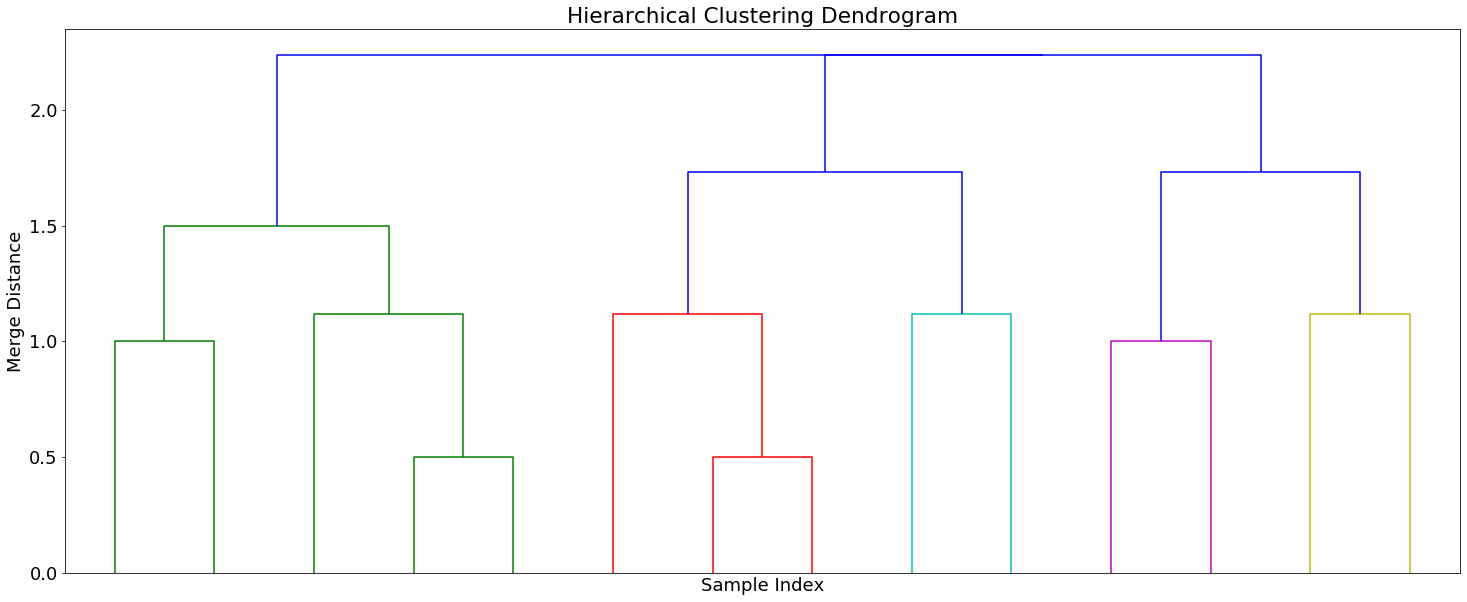

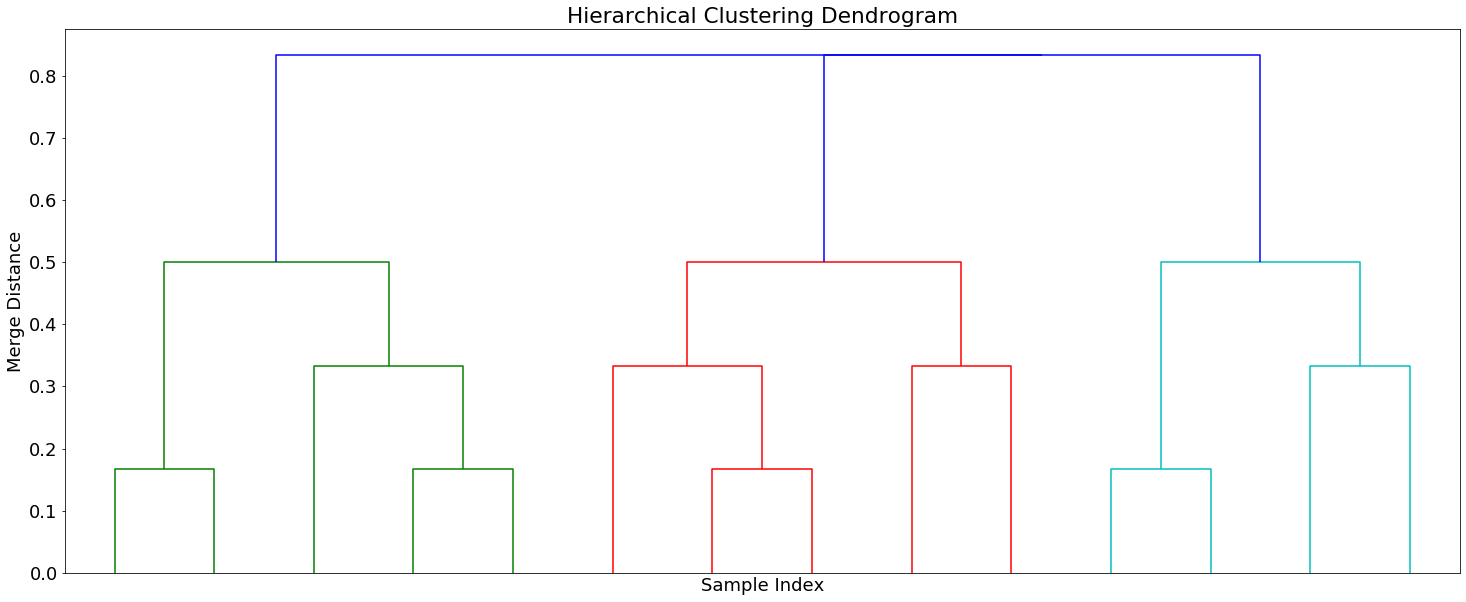

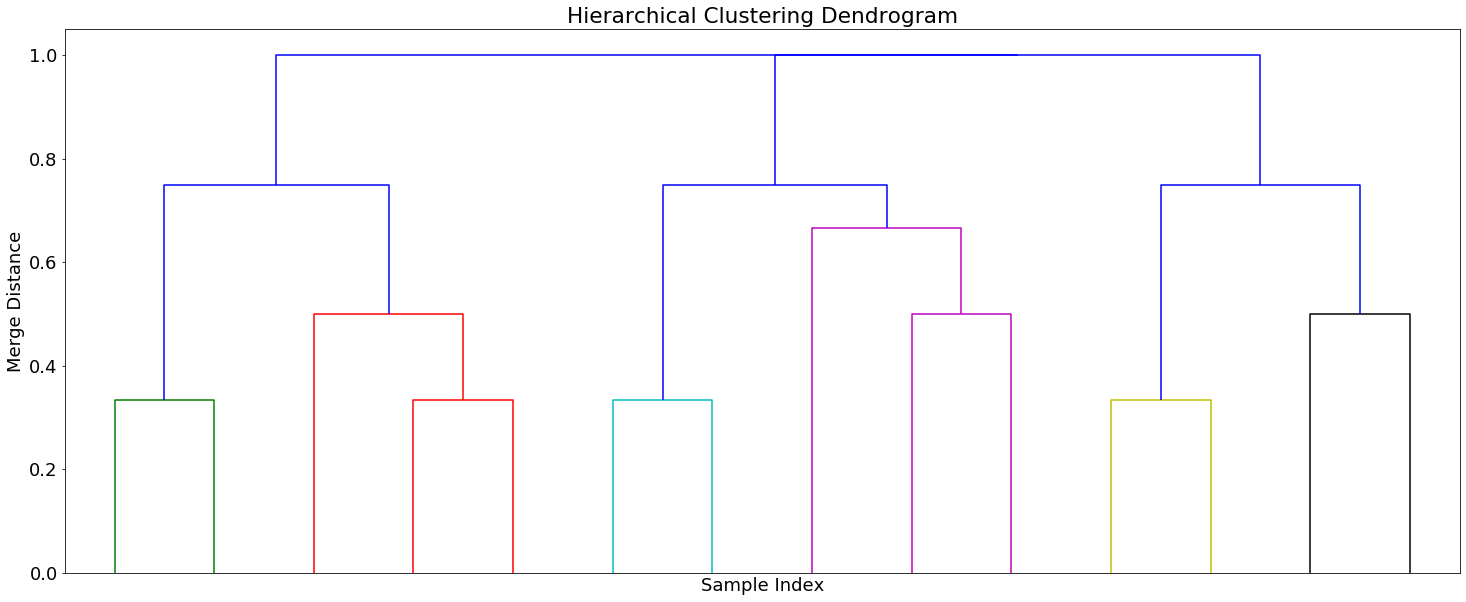

In [12]:
Z = {}
Z['Euclidean'] = linkage(df_numerical, 'complete')
Z['Hamming'] = linkage(df_numerical, 'complete', metric='hamming')
Z['Jaccard'] = linkage(df_numerical, 'complete', metric='jaccard')

for key in Z.keys():
    PlotDendrogram(Z[key], key+' Distance')

Note that there are no cuts for two clusters so if we ask to produce the clustering for two clusters we will get only one cluster. This applies at other cut points so we can compute WSS and BSS only for some values of k (the missing ones are equivalent to the previous value).

In [13]:
for k in range(1,10):
    print(str(fcluster(Z['Euclidean'], k , criterion='maxclust')))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 3 1 1 1 3 2 2 1 2 3 3 1]
[2 2 3 1 1 1 3 2 2 1 2 3 3 1]
[2 2 4 1 1 1 5 2 3 1 3 5 4 1]
[3 3 5 1 2 2 6 3 4 2 4 6 5 1]
[3 3 5 1 2 2 6 3 4 2 4 6 5 1]
[3 3 5 1 2 2 6 3 4 2 4 6 5 1]
[3 3 5 1 2 2 6 3 4 2 4 6 5 1]


In [14]:
wss = {}
bss = {}

for key in Z.keys():
    wss[key], bss[key] = ComputeWSSBSS(df_numerical, Z[key], range(1,10))

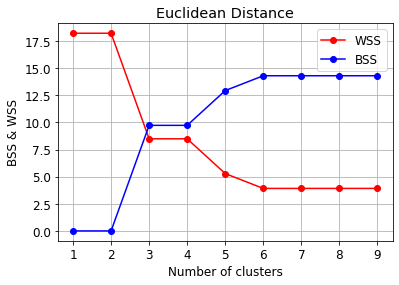

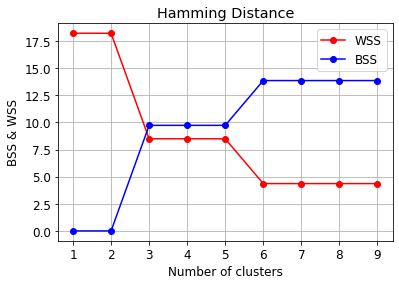

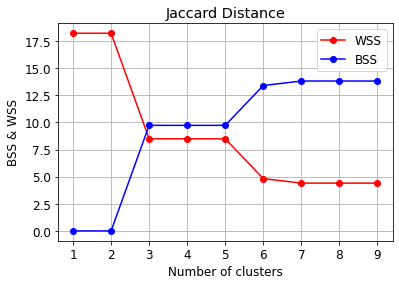

In [16]:
for key in Z.keys():
    PlotKneeElbow(bss[key],wss[key],range(1,10),key+' Distance')